In [71]:
import os
import os.path as osp
import json
import pickle
import collections as C
import itertools as I
import random
import math
from typing import Dict, List, Union, Tuple, Optional

import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import make_interp_spline
import matplotlib.cm as cm

from common.constants import CORE_OPTIONS
from common.utils import remove_comments, normalize_spaces, remove_spaces
from common.pantograph.dataclasses import ProblemGenerationProcess

In [80]:
def count_kc(d: ProblemGenerationProcess) -> int:
    try:
        if 'proving_results' in d.metainfo:
            return len(remove_spaces(remove_comments(d.formal_solution_draft)))
        else:
            return d.metainfo['eval_result']['KC']
    except:
        # return len(remove_spaces(remove_comments(d.formal_solution_draft)))
        return float('nan')


NAME_MAPPING = {
    "autoformalization_pg_kimina7b-PromptCoT-DS_kimina7b-valid_samples.jsonl" : "PromptCoT-DS",
    "autoformalization_pg_kimina7b-PromptCoT-QwQ_kimina7b-valid_samples.jsonl" : "PromptCoT-QwQ",
    "autoformalization_pg_kimina7b-ScaleQuest-Math_kimina7b-valid_samples.jsonl" : "ScaleQuest-Math",
    "MUSTARDSauce_lean4_parsed-valid_samples.jsonl" : "MUSTARD",
    "sft_ar_v3-Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch.0913.staged-valid_samples.jsonl" : "Ablation (Staged)",
    "sft_ar_v3-Goedel-Prover-V2-8B.Numina-Lean-reasseblmed.39509.problem_generator.nopack.3epoch-valid_samples.jsonl" : "Main",
    "sft_wg_starified-Goedel-Prover-V2-8B.Numina-Lean.whole_statement_generatior.nopack-valid_samples.jsonl" : "Ablation (WSG)"
}
sample_data = dict()

for p in os.listdir('/sfs/liuqi/data/fpg_valid_fixed_evaluated'):
    benchmark_name = NAME_MAPPING[p]
    with open(osp.join('/sfs/liuqi/data/fpg_valid_fixed_evaluated', p), 'r') as f:
        data = [json.loads(l) for l in f.readlines()]
    
    with open(osp.join('/sfs/liuqi/data/fpg_valid_formal', p), 'r') as f:
        data_formal = [json.loads(l) for l in f.readlines()]
    
    assert len(data) == len(data_formal)
    for (d_i, d_f) in zip(data, data_formal):
        for k in ['header', 'formal_statement', 'formal_proof', 'condition', 'index', 'src']:
            assert d_i[k] == d_f[k]
    
    # sample_data = [(d_f['kc'], 0, True) if d['informalization']['problem_type'] == "Proof Question" else (
    #         d_f['kc'],
    #         len(d['informalization']['eval_results']['succeeded'])/(len(d['informalization']['eval_results']['succeeded'])+len(d['informalization']['eval_results']['failed'])),
    #         False
    #     )
    #     for (d, d_f) in zip(data, data_formal)]
    
    
    results = []
    for (d, d_f) in zip(data, data_formal):
        if d['informalization']['problem_type'] == "Proof Question":
            results.append((d_f['kc'], 0, True))
        else:
            assert len(d['informalization']['eval_results']['succeeded'])+len(d['informalization']['eval_results']['failed']) == 6
            results.append((
                d_f['kc'],
                1 - len(d['informalization']['eval_results']['succeeded'])/6,
                False
            ))
    sample_data[benchmark_name] = results

In [87]:
def visualize_data(data: Dict[str, List[Tuple[float, float, bool]]], 
                   figsize: Tuple[int, int] = (24, 16),
                   dpi: int = 100) -> None:
    """
    可视化实验数据，展示不同复杂度区间内各实验的结果数量及难度分布
    低难度（0）显示为绿色，高难度（1）显示为红色
    不同实验使用不同纹理图案区分，重采样样本(is_resampled=True)显示为白色
    """
    # 定义复杂度区间
    # bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, float('inf')]
    bins = [0, 200, 400, 600, 800, 1000, float('inf')]
    bin_labels = [
        '0~200', '200~400', '400~600', '600~800', '800~1000', '1000+', 'inf'
    ]
    num_bins = len(bin_labels)
    
    # 获取所有实验名称
    exp_names = ["Main", "Ablation (Staged)", "Ablation (WSG)", "PromptCoT-DS", "PromptCoT-QwQ", "MUSTARD", "ScaleQuest-Math"]
    num_experiments = len(exp_names)
    
    # 定义实验的纹理图案和对应颜色
    hatches = ['', '..', '//', '\\', 'xx', '++', '--', '*']
    hatch_colors = ['black'] * len(hatches)  # 纹理统一使用黑色
    
    # 调整图案数量以匹配实验数量
    if num_experiments > len(hatches):
        hatches = [hatches[i % len(hatches)] for i in range(num_experiments)]
        hatch_colors = [hatch_colors[i % len(hatch_colors)] for i in range(num_experiments)]
    else:
        hatches = hatches[:num_experiments]
        hatch_colors = hatch_colors[:num_experiments]
    
    # 为每个实验和每个区间准备数据
    # 总计数（包括重采样样本）
    total_counts = {exp: [0]*num_bins for exp in exp_names}
    # 正常样本的难度（不包括重采样样本）
    normal_difficulties = {exp: [[] for _ in range(num_bins)] for exp in exp_names}
    # 重采样样本的计数
    resampled_counts = {exp: [0]*num_bins for exp in exp_names}
    
    # 填充数据
    for exp, results in data.items():
        for complexity, difficulty, is_resampled in results:
            # 确保难度值在[0,1]范围内（仅对非重采样样本有效）
            difficulty = max(0, min(1, difficulty))
            
            # 确定属于哪个复杂度区间
            for bin_idx in range(num_bins):
                if bin_idx < num_bins - 1:
                    if bins[bin_idx] <= complexity < bins[bin_idx+1]:
                        total_counts[exp][bin_idx] += 1
                        if is_resampled:
                            resampled_counts[exp][bin_idx] += 1
                        else:
                            normal_difficulties[exp][bin_idx].append(difficulty)
                        break
                else:  # 最后一个区间是inf
                    total_counts[exp][bin_idx] += 1
                    if is_resampled:
                        resampled_counts[exp][bin_idx] += 1
                    else:
                        normal_difficulties[exp][bin_idx].append(difficulty)
                    break
    
    # 计算最大计数用于设置y轴范围
    max_count = max(max(exp_counts) for exp_counts in total_counts.values())
    
    # 设置柱状图的宽度和间距
    bar_width = 0.8 / num_experiments
    x = np.arange(num_bins)
    
    # 创建图表
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # 创建绿色到红色的颜色映射（用于非重采样样本）
    colors = [(0, 1, 0), (1, 1, 0), (1, 0, 0)]  # 绿->黄->红
    cmap = LinearSegmentedColormap.from_list('difficulty_cmap', colors, N=100)
    
    # 为每个实验绘制柱子
    for i, exp in enumerate(exp_names):
        bar_x = x - 0.4 + bar_width/2 + i * bar_width
        hatch = hatches[i]
        h_color = hatch_colors[i]
        
        for bin_idx in range(num_bins):
            total_count = total_counts[exp][bin_idx]
            if total_count == 0:
                continue  # 跳过没有数据的区间
            
            # 获取正常样本和重采样样本数量
            normal_count = total_count - resampled_counts[exp][bin_idx]
            resample_count = resampled_counts[exp][bin_idx]
            
            # 1. 绘制正常样本部分（按难度分布）
            current_bottom = 0

            # 2. 绘制重采样样本部分（白色，不参与难度分布）
            if resample_count > 0:
                ax.bar(
                    bar_x[bin_idx], resample_count, bottom=current_bottom, width=bar_width*0.9,
                    color='white',  # 重采样样本显示为白色
                    edgecolor='darkgray',
                    linewidth=0.3,
                    hatch=hatch,
                    alpha=0.9
                )
                current_bottom += resample_count

            if normal_count > 0:
                diffs = normal_difficulties[exp][bin_idx]
                # 将[0,1]区间分成20个小间隔
                heatmap_bins = np.linspace(0, 1, 21)
                # 计算每个难度区间的样本数量
                diff_counts, _ = np.histogram(diffs, bins=heatmap_bins)
                
                for h_idx in range(len(diff_counts)):
                    segment_height = diff_counts[h_idx]
                    if segment_height == 0:
                        continue
                    
                    # 难度值取区间中点作为颜色映射依据
                    difficulty_value = (heatmap_bins[h_idx] + heatmap_bins[h_idx+1]) / 2
                    
                    ax.bar(
                        bar_x[bin_idx], segment_height, bottom=current_bottom, width=bar_width*0.9,
                        color=cmap(difficulty_value),
                        edgecolor='darkgray',
                        linewidth=0.3,
                        hatch=hatch,
                        alpha=0.9
                    )
                    
                    current_bottom += segment_height
            

    
    # 设置图表属性
    ax.set_xlabel('Complexity Range', fontsize=12)
    ax.set_ylabel('Number of Results', fontsize=12)
    ax.set_title('Distribution of Generation Results by Complexity and Difficulty', fontsize=14, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(bin_labels, rotation=45, ha='right', fontsize=10)
    ax.set_ylim(0, max_count * 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 添加颜色条（仅表示正常样本的难度）
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax)
    cbar.set_label('Difficulty (0=Low, 1=High)', rotation=270, labelpad=20)
    
    # 添加图例
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=cmap(0.5), 
                                    edgecolor='darkgray', hatch=hatches[i],) 
                      for i, _ in enumerate(exp_names)]
    # 添加重采样样本的图例说明
    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor='white', 
                                        edgecolor='darkgray', hatch='',))
    exp_names_with_resample = exp_names + ['Resampled']
    ax.legend(legend_elements, exp_names_with_resample, loc='upper right', title='Experiments')
    
    plt.tight_layout()
    plt.show()

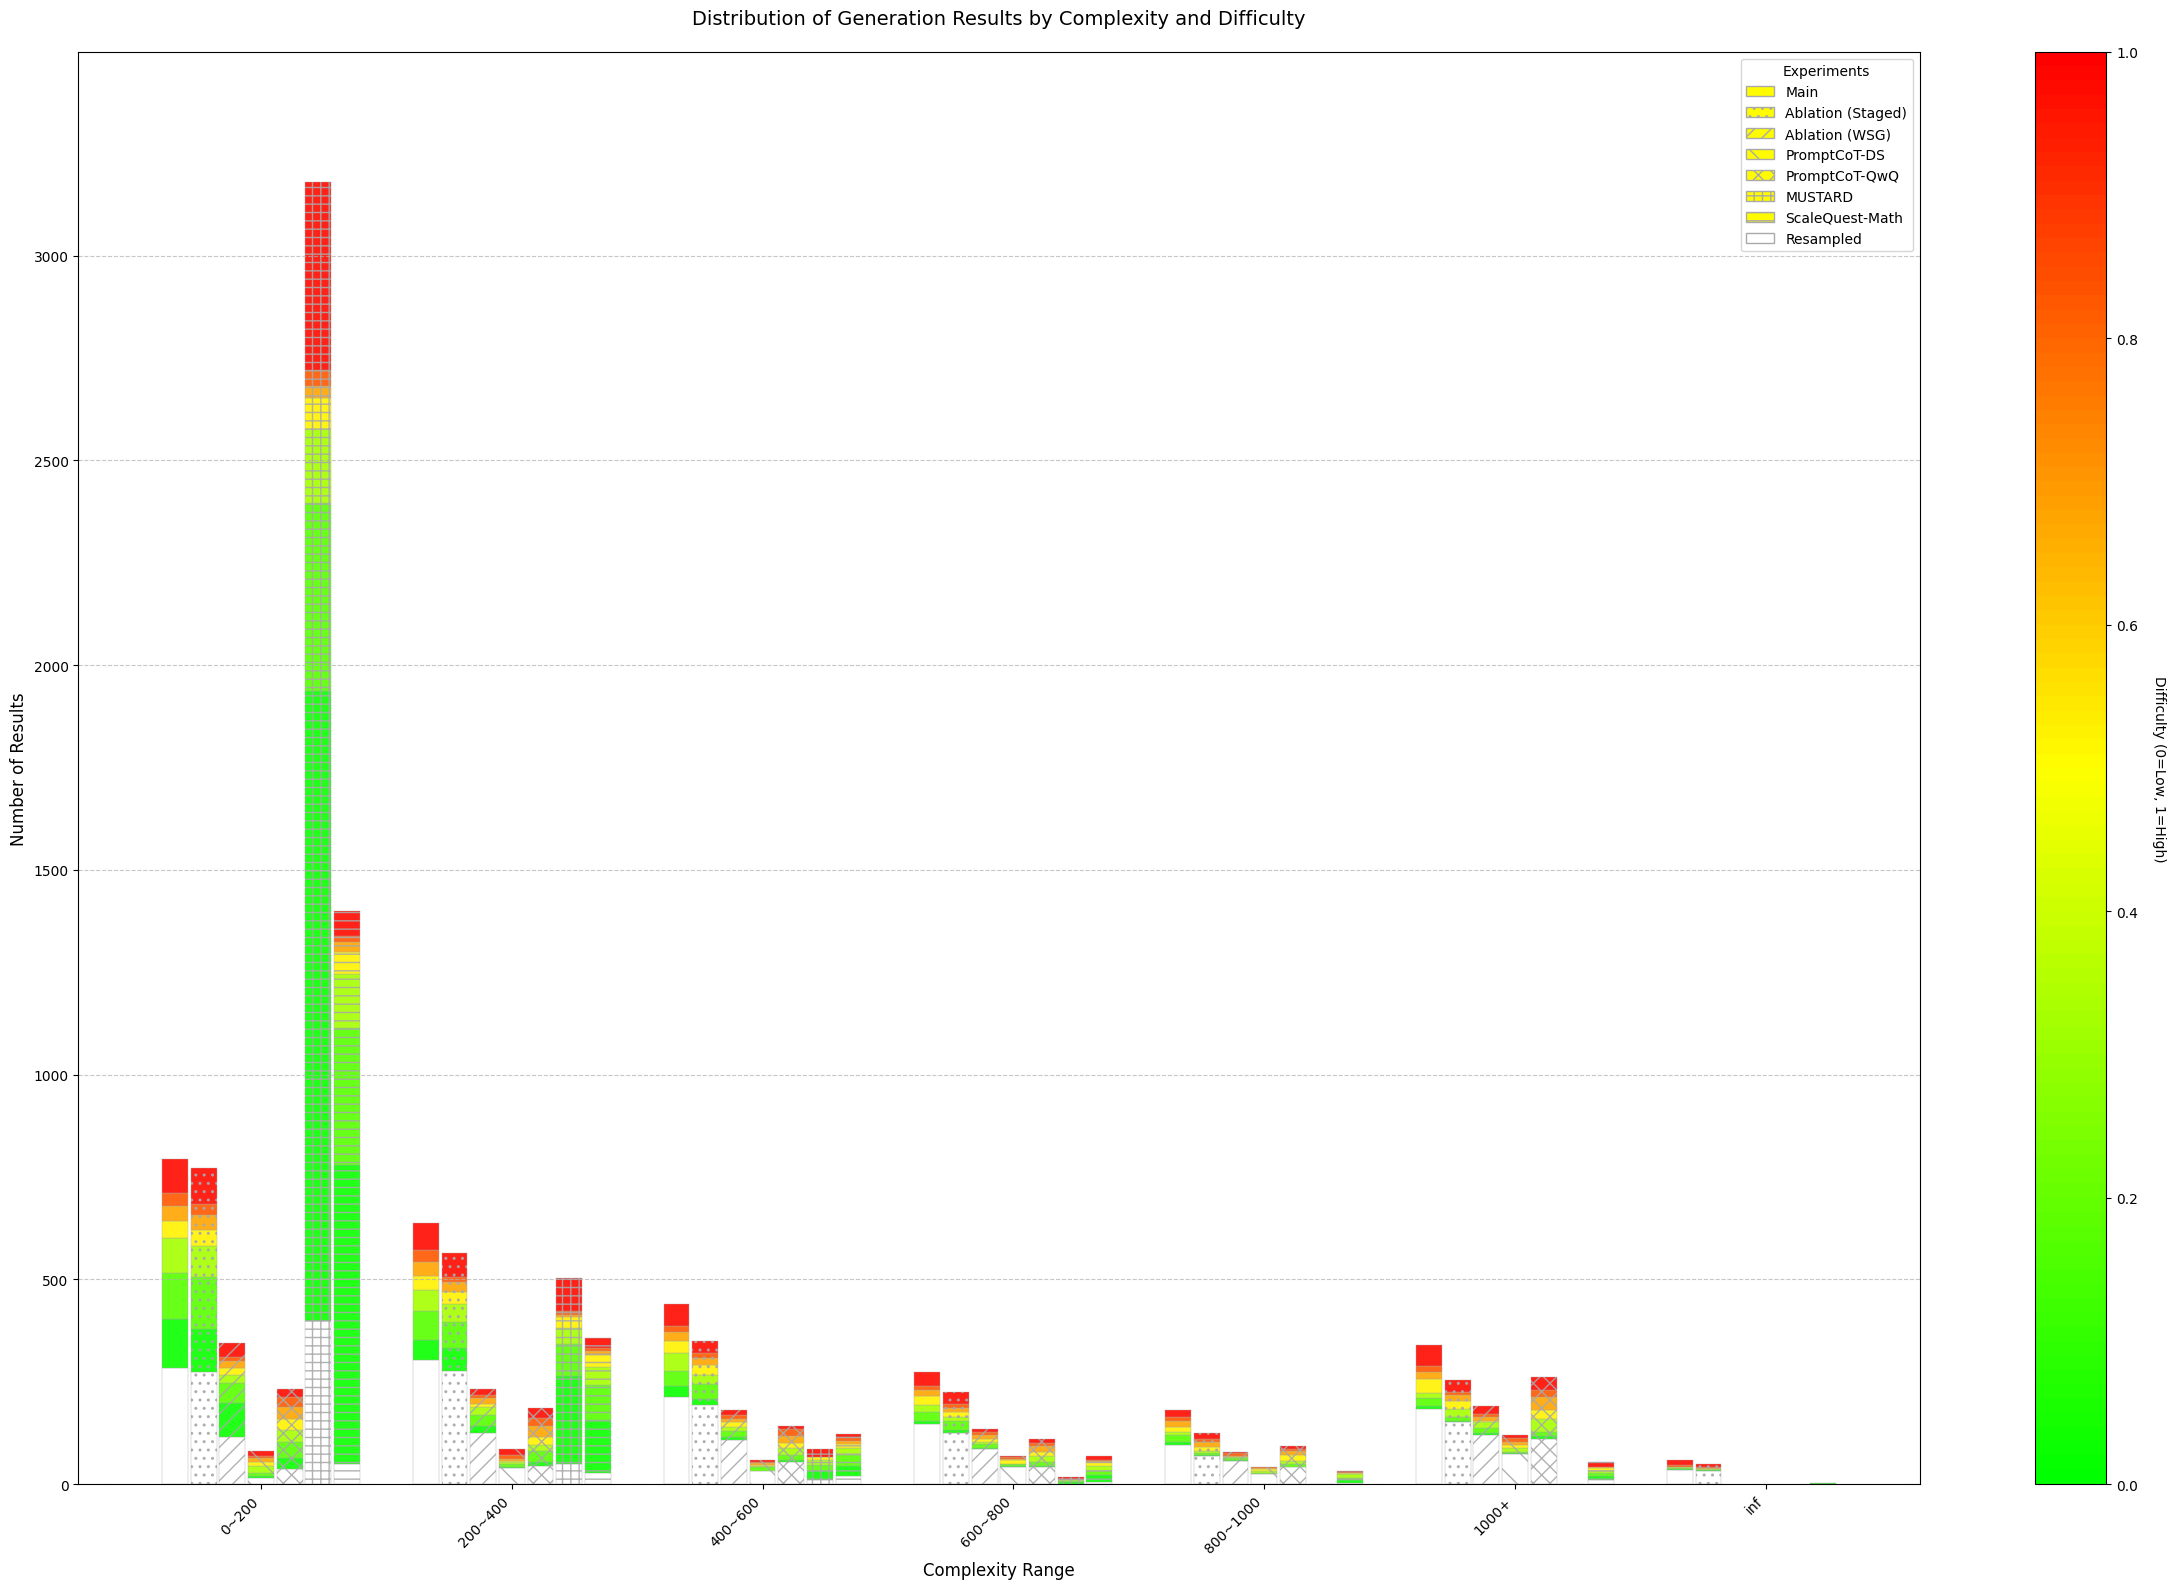

In [88]:
# np.random.seed(42)

# def generate_sample_data(num_samples: int, resample_ratio: float = 0.2) -> List[Tuple[float, float, bool]]:
#     complexities = []
#     # 大部分数据分布在0~1000
#     complexities.extend(np.random.uniform(0, 1000, int(num_samples * 0.9)))
#     # 一些1000+的数据
#     complexities.extend(np.random.uniform(1000, 1500, int(num_samples * 0.08)))
#     # 少量inf数据
#     complexities.extend([float('inf')] * int(num_samples * 0.02))
    
#     # 难度在[0,1]之间
#     difficulties = np.random.beta(2, 2, num_samples)
    
#     # 随机生成重采样标记
#     is_resampled = np.random.choice([True, False], size=num_samples, p=[resample_ratio, 1-resample_ratio])
    
#     return list(zip(complexities, difficulties, is_resampled))

# sample_data = {
#     "Experiment A": generate_sample_data(500),
#     "Experiment B": generate_sample_data(700),
#     "Experiment C": generate_sample_data(600)
# }

visualize_data(sample_data)